# pl

> Phase Linking

<!-- Phase linking for PTA requires `cupy.optimize` to be implented which is tracked at
https://github.com/rapidsai/raft/pull/923
and https://github.com/cupy/cupy/issues/6112 -->

In [ ]:
#| default_exp pl

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import numpy as np
import zarr
import moraine as mr
from moraine.utils_ import is_cuda_available
if is_cuda_available():
    import cupy as cp
from matplotlib import pyplot as plt

In [ ]:
#| export
import numpy as np
import moraine as mr
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
from numba import prange
from moraine.utils_ import ngpjit

## EMI

In [ ]:
#| hide
# This function is now deprecated
if is_cuda_available():
    def emi_all(coh:cp.ndarray, #coherence ,dtype cupy.complex
           )-> tuple[cp.ndarray,cp.ndarray,cp.ndarray]: # estimated phase history `ph`, dtype complex; estimated covariance, dtype complex; minimum eigvalue, dtype float
        coh_mag = abs(coh)
        coh_mag_inv = cp.linalg.inv(coh_mag)
        min_eigval, min_eig = cp.linalg.eigh(coh_mag_inv*coh)
        min_eigval = min_eigval[...,0]
        min_eig = min_eig[...,0]
        min_eig = min_eig*cp.sqrt(min_eig.shape[-1])/cp.linalg.norm(min_eig,axis=-1)[...,None] # equality constrain
        min_eig = 1/min_eig.conj()
        abs_min_eig = abs(min_eig)
    
        estimated_coh = min_eigval[:,None,None]*coh_mag*cp.matmul(min_eig[...,None],min_eig[...,None,:].conj())
        return min_eig/abs_min_eig, estimated_coh, min_eigval

In [ ]:
#| export
if is_cuda_available():
    def _emi_cp(
        coh, # complex coherence metrix, dtype, cp.complex64
        n_images,
        image_pairs,
        ref:int=0,
    ):
        n_points = coh.shape[0]
        max_batch_size = 2**20
        num_batchs = np.ceil(n_points/max_batch_size).astype(int)
        ph = cp.empty((n_points,n_images),dtype=coh.dtype)
        emi_quality = cp.empty(n_points, dtype=cp.float32)
        for i in range(num_batchs):
            start = i*max_batch_size
            end = (i+1)*max_batch_size
            if end >= n_points: end = n_points
            _coh = mr.uncompress_coh(coh[start:end],image_pairs)
            coh_mag = cp.abs(_coh)
            coh_mag_inv = cp.linalg.inv(coh_mag)
            min_eigval, min_eig = cp.linalg.eigh(coh_mag_inv*_coh)
            min_eigval = min_eigval[...,0]
            min_eig = min_eig[...,0]*min_eig[...,[ref],0].conj()
            ph[start:end] = min_eig/abs(min_eig)
            emi_quality[start:end] = min_eigval
        return ph, emi_quality

In [ ]:
#| export
@ngpjit
def _emi_numba(
    coh,
    n_images,
    image_pairs,
    ref:int=0,
):
    n_points = coh.shape[0]
    ph = np.empty((n_points,n_images),dtype=coh.dtype)
    emi_quality = np.empty(n_points,dtype=np.float32)
    for i in prange(n_points):
        _coh = mr.uncompress_single_coh_numba(coh[i],n_images,image_pairs)
        coh_mag = np.abs(_coh)
        coh_mag_inv = np.linalg.inv(coh_mag)
        min_eigval, min_eig = np.linalg.eigh(coh_mag_inv*_coh)
        min_eigval = min_eigval[0]
        min_eig = min_eig[:,0]*np.conj(min_eig[ref,0])
        for j in range(ph.shape[-1]):
            ph[i,j] = min_eig[j]/abs(min_eig[j])
        emi_quality[i] = min_eigval
    return ph, emi_quality

In [ ]:
#| export
def emi(coh:np.ndarray, #complex coherence metrix,dtype cupy.complex
        ref:int=0, #index of reference image in the phase history output, optional. Default: 0
       )-> tuple[np.ndarray,np.ndarray]: # estimated phase history `ph`, dtype complex; quality (minimum eigvalue, dtype float)
    xp = get_array_module(coh)
    nimages = mr.nimage_from_npair(coh.shape[-1])
    image_pairs = mr.TempNet.from_bandwidth(nimages).image_pairs
    if xp is np:
        return _emi_numba(coh,nimages,image_pairs,ref)
    else:
        return _emi_cp(coh,nimages,image_pairs,ref)

In [ ]:
# #| export
# def emi(coh:np.ndarray, #complex coherence metrix,dtype cupy.complex
#         ref:int=0, #index of reference image in the phase history output, optional. Default: 0
#        )-> tuple[np.ndarray,np.ndarray]: # estimated phase history `ph`, dtype complex; quality (minimum eigvalue, dtype float)
#     xp = get_array_module(coh)
#     coh_mag = xp.abs(coh)
#     coh_mag_inv = xp.linalg.inv(coh_mag)
#     min_eigval, min_eig = xp.linalg.eigh(coh_mag_inv*coh)
#     min_eigval = min_eigval[...,0]
#     # min_eig = min_eig[...,0]
#     min_eig = min_eig[...,0]*min_eig[...,[ref],0].conj()

#     return min_eig/abs(min_eig), min_eigval

`emi` is a phase estimator base on Eigendecomposition-based Maximum-likelihood-estimator of Interferometric phase (EMI) [@ansariEfficientPhaseEstimation2018] phase linking method.

The amplitude of `coh` should range between 0 and 1 and the phase of `coh` should be the interferometric phase.
The returned phase is also complex but the amplitude is setted to 1.
The quality factor is a measure for the inadequacy of EMI's model that adding real-valued dyadic for calibration of real coherence matrix which is generally poorly estimated.
It is supposed to larger than 1 and smaller means better.

::: {.callout-important}
This function is deprecated as estimate coherence for all pixels are not necessary. Please use `emperical_co_pc` instead.
:::

Example:
Complex coherence matrix from a stack of 17 SLC images:

In [ ]:
rslc = zarr.open('../../data/rslc.zarr/',mode='r')[:]

# SHP selection
az_half_win = 5; r_half_win = 5
az_win = 2*az_half_win+1; r_win = 2*r_half_win+1

rmli = np.abs(rslc)**2

p = mr.ks_test(rmli,az_half_win=az_half_win,r_half_win=r_half_win)
is_shp = p < 0.05

# Select DS candidate
shp_num = np.count_nonzero(is_shp,axis=(-2,-1))
is_ds_can = shp_num >= 50

ds_can_is_shp = is_shp[is_ds_can]
ds_can_idx = np.stack(np.where(is_ds_can),axis=-1)
ds_can_coh = mr.emperical_co_pc(rslc,ds_can_idx,ds_can_is_shp)
print(ds_can_coh.shape)

(732727, 136)


In [ ]:
%%time
ds_can_ph, ds_can_emi_quality = emi(ds_can_coh)
print(ds_can_ph.shape, ds_can_emi_quality.shape)

(732727, 17) (732727,)
CPU times: user 35.1 s, sys: 1.52 s, total: 36.6 s
Wall time: 4.11 s


In [ ]:
ds_can_emi_quality_2d = np.empty_like(is_ds_can,dtype=ds_can_emi_quality.dtype)
ds_can_emi_quality_2d[:] = np.nan
ds_can_emi_quality_2d[is_ds_can] = ds_can_emi_quality

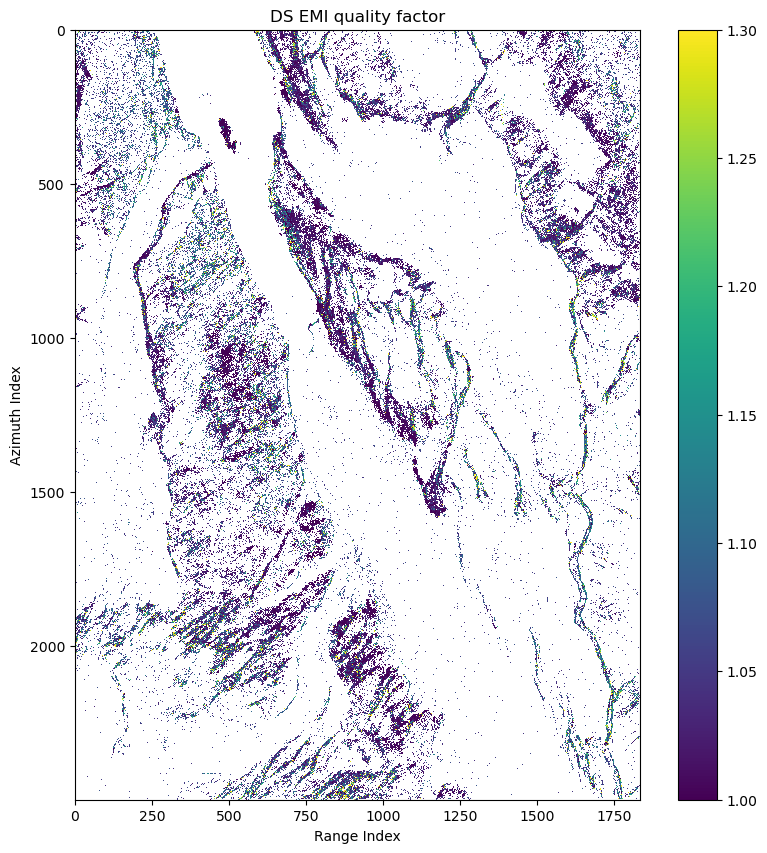

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(ds_can_emi_quality_2d,interpolation='nearest',vmin=1,vmax=1.3)
ax.set(title='DS EMI quality factor',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

`cupy.ndarray` is also supported:

In [ ]:
if is_cuda_available():
    ds_can_ph_, ds_can_emi_quality_ = emi(cp.asarray(ds_can_coh))

In [ ]:
#| hide
# gpu and cpu can generate very different result!!!
# if is_cuda_available():
#     np.testing.assert_array_almost_equal(ds_can_ph, cp.asnumpy(ds_can_ph_),decimal=4)

In [ ]:
#| hide
# if is_cuda_available():
#     np.testing.assert_array_almost_equal(ds_can_emi_quality, cp.asnumpy(ds_can_emi_quality_),decimal=4)

## Temporal Coherence for Distributed Scatterer

In [ ]:
#| export
@ngpjit
def _ds_temp_coh_numba(
    coh:np.ndarray,# complex coherence metrix, dtype np.complex64
    ph:np.ndarray, # complex phase history, dtype np.complex64
    image_pairs:np.ndarray, # image pairs
):
    nimages = ph.shape[-1]
    n_points = ph.shape[0]
    n_image_pairs = image_pairs.shape[0]
    temp_coh = np.empty(n_points,dtype=np.float32)
    for i in prange(n_points):
        _ph = ph[i]
        _coh = coh[i]
        _t_coh = np.complex64(0.0)
        for j in range(n_image_pairs):
            n, k = image_pairs[j,0],image_pairs[j,1]
            int_conj_ph = np.conjugate(_ph[n])*_ph[k]
            diff_ph = _coh[j]*int_conj_ph/np.abs(_coh[j])
            _t_coh += diff_ph
        temp_coh[i] = np.abs(_t_coh)/n_image_pairs
    return temp_coh

In [ ]:
#| export
if is_cuda_available():
    _ds_temp_coh_kernel = cp.ElementwiseKernel(
        'raw T coh, raw T ph, raw I image_pairs, int32 n_points, int32 nimages, int32 n_image_pairs',
        'raw float32 temp_coh',
        '''
        if (i >= n_points) return;
        T _t_coh = T(0.0,0.0);
        int j; int n; int k;
        int coh_idx; int ph_n_idx; int ph_k_idx;
        for (j = 0; j< n_image_pairs; j++){
            n = image_pairs[j*2];
            k = image_pairs[j*2+1];
            coh_idx = i*n_image_pairs+j;
            ph_n_idx = i*nimages+n;
            ph_k_idx = i*nimages+k;
            _t_coh += coh[coh_idx]/sqrt(norm(coh[coh_idx]))*conj(ph[ph_n_idx])*ph[ph_k_idx];
        }
        temp_coh[i] = abs(_t_coh)/n_image_pairs;
        ''',
        name = 'ds_temp_coh_kernel',no_return=True,
    )

In [ ]:
#| export
def ds_temp_coh(coh:np.ndarray,# complex coherence metrix, np.complex64 or cp.complex64
                ph:np.ndarray, # complex phase history, np.complex64 or cp.complex64
                image_pairs:np.ndarray=None, # image pairs, all image pairs by default
                block_size:int=128, # the CUDA block size, only applied for cuda
            ):
    xp = get_array_module(coh)
    n_points = ph.shape[0]
    nimages = ph.shape[-1]
    if image_pairs is None:
        image_pairs = mr.TempNet.from_bandwidth(nimages).image_pairs
    image_pairs = image_pairs.astype(np.int32)
    
    if xp is np:
        return _ds_temp_coh_numba(coh,ph,image_pairs)
    else:
        image_pairs = cp.asarray(image_pairs)
        n_image_pairs = image_pairs.shape[0]
        temp_coh = cp.empty(n_points, dtype=cp.float32)
        _ds_temp_coh_kernel(coh, ph, image_pairs, cp.int32(n_points),cp.int32(nimages),cp.int32(n_image_pairs), temp_coh, size=n_points, block_size=block_size)
        return temp_coh

::: {.callout-warning}
This function is deprecated and will be removed in the future release. Please use `temp_coh` from [Pixel Quality Metrics](../pqm.ipynb).
:::

This function estimate the temporal coherence of as

$$\gamma = \frac{1}{N_{IP}} \left| \sum_{n, k \in IP} e^{i\phi_{nk}} e^{-i(\theta_n-\theta_k)} \right| $$

Where $\phi_{nk}$ is the phase of complex interferogram/coherence matrix, $\theta_{n}$ is the phase of rslc or phase after phase linking, $IP$ is the image pairs, $N_{IP}$ is the number of image pairs.

If all image pairs are considered, then it is:

$$\gamma = \frac{2}{N^2-N} \left| \sum_{n=1}^{N} \sum_{k=n+1}^{N} e^{i\phi_{nk}} e^{-i(\theta_n-\theta_k)} \right| $$

In [ ]:
#| hide
# one question: do we need to compare all possible combinations or 
# just the one with good coherence?

In [ ]:
rslc = zarr.open('../../data/rslc.zarr/',mode='r')[:]

# SHP selection
az_half_win = 5; r_half_win = 5
az_win = 2*az_half_win+1; r_win = 2*r_half_win+1

rmli = np.abs(rslc)**2
p = mr.ks_test(rmli,az_half_win=az_half_win,r_half_win=r_half_win)
is_shp = p < 0.05

# Select DS candidate
shp_num = np.count_nonzero(is_shp,axis=(-2,-1))
is_ds_can = shp_num >= 50

ds_can_is_shp = is_shp[is_ds_can]
ds_can_idx = np.stack(np.where(is_ds_can),axis=-1)
ds_can_coh = mr.emperical_co_pc(rslc,ds_can_idx,ds_can_is_shp)
ds_can_ph = emi(ds_can_coh)[0]
print(ds_can_coh.shape,ds_can_ph.shape)

(732727, 136) (732727, 17)


In [ ]:
ds_can_temp_coh = ds_temp_coh(ds_can_coh,ds_can_ph)
print(ds_can_temp_coh.shape)
if is_cuda_available():
    ds_can_temp_coh_cp = ds_temp_coh(cp.asarray(ds_can_coh), cp.asarray(ds_can_ph))
    np.testing.assert_array_almost_equal(ds_can_temp_coh, ds_can_temp_coh_cp.get())

(732727,)


In [ ]:
ds_can_temp_coh_2d = np.empty_like(is_ds_can,dtype=ds_can_temp_coh.dtype)
ds_can_temp_coh_2d[:] = np.nan
ds_can_temp_coh_2d[is_ds_can] = ds_can_temp_coh

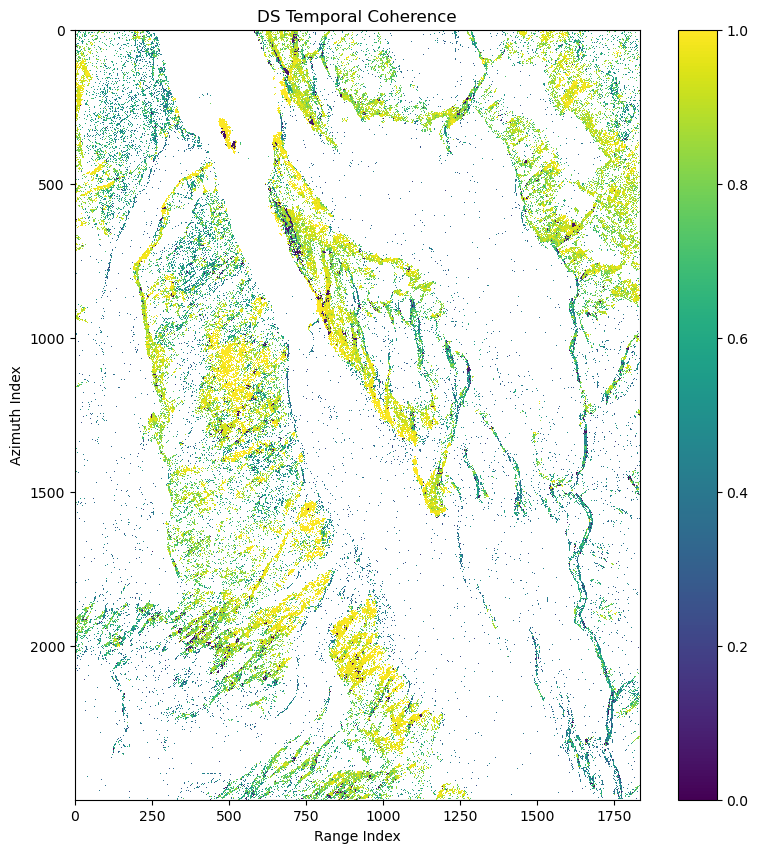

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(ds_can_temp_coh_2d,interpolation='nearest',vmin=0,vmax=1)
ax.set(title='DS Temporal Coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| export
def emperical_co_emi_temp_coh_pc(
    rslc:np.ndarray, # rslc stack, dtype:'np.complex64'
    idx:np.ndarray, # index of point target (azimuth_index, range_index), dtype: `np.int32`, shape: (n_pc, 2)
    pc_is_shp:np.ndarray, # shp bool, dtype:'np.bool'
    batch_size:int=1000,
):
    xp = get_array_module(rslc)
    n_pc = idx.shape[0]
    nimages = rslc.shape[2]
    ph = xp.empty((n_pc, nimages),dtype=xp.complex64)
    emi_quality = xp.empty(n_pc,dtype=np.float32)
    t_coh = xp.empty(n_pc,dtype=np.float32)
    batch_bounds = np.arange(0,n_pc+batch_size,batch_size)
    # I forgot why I have to split data into batches, probably due to memory issue.
    if batch_bounds[-1]>n_pc: batch_bounds[-1]=n_pc
    for i in range(batch_bounds.shape[0]-1):
        start = batch_bounds[i]; stop = batch_bounds[i+1]
        _coh = mr.co.emperical_co_pc(rslc,idx[start:stop],pc_is_shp[start:stop])
        ph[start:stop],emi_quality[start:stop] = emi(_coh)
        t_coh[start:stop] = ds_temp_coh(_coh,ph[start:stop])
    return ph, emi_quality, t_coh

`emperical_co_emi_temp_coh_pc` is the combination of `emperical_co_pc`, `emi` and `ds_temp_coh`.
But it does not return the coherence matrix as the full coherence matrix may be too big to fill the memory.
The functions provide the `batch_size` options to do the processing in batch.

In [ ]:
rslc = zarr.open('../../data/rslc.zarr/',mode='r')[:]

# SHP selection
az_half_win = 5; r_half_win = 5
az_win = 2*az_half_win+1; r_win = 2*r_half_win+1

rmli = np.abs(rslc)**2
p = mr.ks_test(rmli,az_half_win=az_half_win,r_half_win=r_half_win)
is_shp = p < 0.05

# Select DS candidate
shp_num = np.count_nonzero(is_shp,axis=(-2,-1))
is_ds_can = shp_num >= 50

ds_can_is_shp = is_shp[is_ds_can]
ds_can_idx = np.stack(np.where(is_ds_can),axis=-1)

In [ ]:
ds_can_ph, ds_can_emi_quality, ds_can_t_coh = emperical_co_emi_temp_coh_pc(rslc,ds_can_idx,ds_can_is_shp,batch_size=1000)

In [ ]:
ds_can_coh_ = mr.emperical_co_pc(rslc,ds_can_idx,ds_can_is_shp)
ds_can_ph_, ds_can_emi_quality_ = emi(ds_can_coh_)
ds_can_t_coh_ = ds_temp_coh(ds_can_coh_,ds_can_ph_)
np.testing.assert_array_equal(ds_can_ph,ds_can_ph_)
np.testing.assert_array_equal(ds_can_emi_quality,ds_can_emi_quality_)
np.testing.assert_array_equal(ds_can_t_coh,ds_can_t_coh_)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()